# Linear Regression

Modelling Life Satisfaction vs. GDP per capita using l. regression.
Regression is calculated the 'standard' way and using K-nearest neighbors.

In [2]:
import pandas as pd
import numpy as np
import numpy.random as random
import os

random.seed(23)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [7]:
# Data from http://stats.oecd.org/index.aspx?DataSetCode=BLI
datapath = "datasets/lifesat/"

oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
# Data is clustered by classes of inequality, were we want all (TOTAL)
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
# Pivoting the table with relevant features
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(2)

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0


In [8]:
# Looking at the data
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

In [9]:
# Loading GDP/capita data
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.head(2)

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0


In [11]:
# Merging both tables by Country
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
full_country_stats.head(2)

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,...,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0


In [22]:
# Looking at Portugal
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["Portugal"]

GDP per capita       19121.592
Life satisfaction        5.100
Name: Portugal, dtype: float64

In [26]:
# The original article removed a few countries as 'missing_data'
# (Brazil, Mexico, Chile, Czech Republic, Norway, Switzerland and Luxembourg)
# I do not know why that is but I'm keeping it

remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

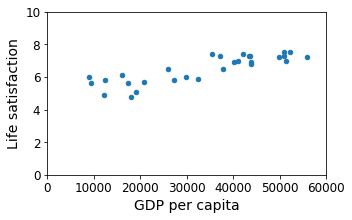

In [27]:
# Plotting data. Seems linearly related
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
plt.show()

In [28]:
# Ok let's see what we get with a simple linear model application
from sklearn import linear_model
lin1 = linear_model.LinearRegression()
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
lin1.fit(Xsample, ysample)
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
t0, t1

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(4.853052800266436, 4.911544589158484e-05)

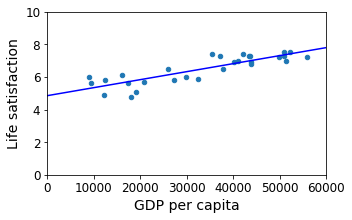

In [29]:
# Plotting the model
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.show()

In [40]:
# Trying with k-neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)
model.fit(Xsample, ysample)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [42]:
# Make a prediction for Portugal (GDP 19121.592)
X_new = np.array([[19121.592]])
print(model.predict(X_new))

[[5.2]]
